In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import rfpimp    # pip install rfpimp
from sklearn.model_selection import train_test_split
from rfpimp import plot_corr_heatmap
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import StandardScaler

sns.set_palette('gist_earth') # colors

In [79]:
data_dir = '../Downloads/'
file = 'Data-DS-ModelingTest.csv'
df_orig = pd.read_csv(f'{data_dir}{file}', parse_dates = True)
print(f'This data has {len(df)} samples of {len(df.columns.values)} features.')


This data has 1673 samples of 18 features.


In [80]:
df_orig.head()

,lead_id,Outcome,Zipcode,MonthlyPremium,CoverageAmount,AgentID,SubmittedDate,Tobacco,Age,Gender,...,AnxietyDepression,ChronicPain,Asthma,BloodPressure,Diabetes,Occupation,BMI,AffordBucket,State,TranscriptText
0,763292,Approved,79912,19.875000,150000,180,6/22/17,N,47,F,...,0,0,0,0,0,Currently Employed,28.2,2,TX,1 It's a great date assurance This is Aar...
1,764999,Approved,19454,30.500000,300000,10586,8/9/17,N,41,M,...,0,0,0,0,0,Currently Employed,28.9,4,PA,1 Hi Thank you for being so patient in th...
2,824545,Approved,74006,33.916667,50000,180,8/10/17,N,60,F,...,0,0,0,0,0,Currently Employed,32.0,4,OK,1 It's a great day in assurance This is A...
3,1035532,Approved,49339,20.541667,50000,90,6/1/17,N,57,M,...,0,1,0,0,0,Currently Employed,30.8,3,MI,1 It's 2 a great day to Sharon sis's ...
4,1045533,Approved,60450,188.333333,1000000,102,6/9/17,N,54,M,...,0,0,0,0,0,Currently Employed,24.4,4,IL,1 It's 2 a great date assurance My na...


# Features
There are several categorical features that are not continuous, we'll need to encode them as categorical features.<br>
- AgentID
- Occupation

<br> The following can be simply converted to binary:
- Tobacco
- Gender
- ExistingPolicy
- Mobile

In [99]:
# Identify Missing Values
miss_fraction = df_orig.isnull().sum()/len(df_orig)
unique_fraction = df_orig.nunique()/len(df_orig)
miss_unique = pd.concat([miss_fraction, unique_fraction], axis=1)
miss_unique = miss_unique.rename(columns = {0: 'missing_fraction', 1: 'unique_fraction'})
miss_unique = miss_unique.apply(lambda x: round(x, 3), axis=0)

miss_unique

,missing_fraction,unique_fraction
lead_id,0.000,0.991
Outcome,0.000,0.001
Zipcode,0.000,0.866
MonthlyPremium,0.000,0.666
CoverageAmount,0.000,0.029
AgentID,0.000,0.110
SubmittedDate,0.000,0.151
Tobacco,0.000,0.001
Age,0.000,0.032
Gender,0.000,0.001


# Missing Data and uniqueness 
We have very little to almost zero missing data so that's great no messy imputation. 
Since LeadId is almost entirely unique, I'm going to drop it since it would likely lead to overfitting. 
Zipcode is nearly unique and too specific to generalize, state is a better geographic and semi-socioeconomic proxy given our limited data. 

In [83]:
# There are several features that require more careful handling than I have time for,
# so I will drop them just to get started.
df = df_orig.copy()

df.drop(['SubmittedDate', 'TranscriptText', 'Zipcode', 'lead_id', 'State'], axis=1, inplace=True)



# Assume the tiny fraction of people who don't have employment status are employed.
# Could be wrong but small impact. 
df = df.fillna({'Occupation': 'Currently Employed'})

# Map the binary variables
dicts = {
    'N': 0, 'Y': 1, 'M': 0, 'F': 1, 'False': 0, 'True': 1, 'Approved': 1, 'Not Approved': 0, 'NotApproved': 0 
}
df.replace(dicts, inplace = True)

# Quickly Encode categoricals - this will work with RF, but for other models it may not be best
df['AgentID'] = df['AgentID'].astype('category')
df['AgentID'] = df['AgentID'].cat.codes

df['Occupation'] = df['Occupation'].astype('category')
df['Occupation'] = df['Occupation'].cat.codes

# sorted(df['AgentID'].unique())


array([1, 0])

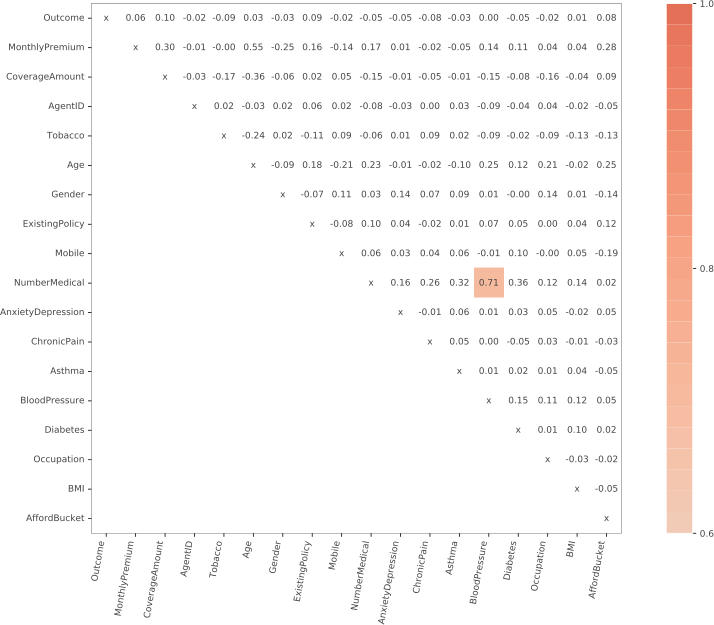

In [86]:
plot_corr_heatmap(df, figsize=(16,9), label_fontsize=9, value_fontsize=9)


In [93]:
# Split the target and features
y = df.iloc[:, 0]
X = df.iloc[:, 1:]

# # Training and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype bool, int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype bool, int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  


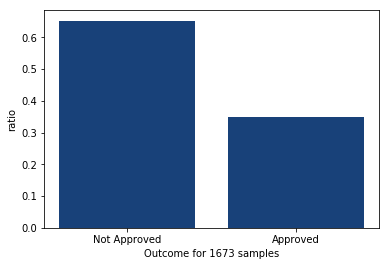

In [94]:
plt.bar([0, 1], np.bincount(y)/len(y))
plt.xlabel(f'Outcome for {len(y)} samples')
plt.ylabel('ratio')
plt.xticks([0,1], ['Not Approved', 'Approved'])
plt.show()

In [97]:
# Lets try some models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

lr_model = LogisticRegression(solver='lbfgs')
lr_balanced_model = LogisticRegression(class_weight='balanced', solver='lbfgs')
rf_model = RandomForestClassifier(n_estimators=50)
rf_balanced_model = RandomForestClassifier(n_estimators=50, class_weight='balanced')
et_model = ExtraTreesClassifier(n_estimators=50)
et_balanced_model = ExtraTreesClassifier(n_estimators=50, class_weight='balanced')

models = {
    'lr_model': lr_model, 'lr_balanced_model': lr_balanced_model, 'rf_model': rf_model, 
    'rf_balanced_model': rf_balanced_model, 'et_model': et_model, 'et_balanced_model': et_balanced_model,
}
scores = {model: None for model in models}

for model in models.keys():
    # Do a 2 fold cross validation to estimate accuracy
    acc_scores = cross_val_score(models[model], X_train_std, y=y_train, scoring='f1', cv=2, n_jobs=-1)
    cv_acc = sum(acc_scores)/len(acc_scores)

    # Predict the test set and check the estimated generalization accuracy
    models[model].fit(X_train_std, y_train)
    prediction = models[model].predict(X_test_std)
    test_acc = accuracy_score(y_test, prediction)
    test_f1 = f1_score(y_test, prediction)
    
    # Keep track of scores
    scores[model] = {'validation_f1': cv_acc, 'test_accuracy': test_acc, 'test_f1': test_f1}
    
    
scores = pd.DataFrame(scores).transpose().sort_values('test_f1', ascending=False)

scores

,test_accuracy,test_f1,validation_f1
lr_balanced_model,0.516418,0.467105,0.431886
et_model,0.626866,0.309392,0.300824
rf_balanced_model,0.623881,0.275862,0.249309
et_balanced_model,0.594030,0.268817,0.292473
rf_model,0.611940,0.207317,0.260780
lr_model,0.623881,0.100000,0.153324


# 1. Which variables did you use as independent variables? What kind of feature engineering did you (or would you) try on these variables?
 <br> Dropping submitteddate because apriori I don't have any knowledge that this would be helpful,
      don't want to spend time on it.
 <br> Dropping TranscriptText because I don't have a super quick way to turn this into features; 
     with more time we could do some  TFIDF features and possibly some sentiment analysis or try to use some canned personality predicting packages. 


# 2. Can you think of any external data that you might be able to merge in to help improve the quality of your predictive model?

Need to better quantify risk of large medical claims given lifestyle factors. Maybe an external dataset that includes any social media data, e.g. stunt man vs. stay at home and knit types. 

# 3. Which algorithms did you (or would you) try for this problem? How would you decide on a final algorithm to use after seeing the results?

Logistic regression (class balanced) has the best F1 score, but it still does not convincingly beat random guessing. 

# 4. If you are unhappy with the accuracy of your model, what might you try next? Or how would you come up with ideas for what to try?

For sure need more careful feature engineering, and additional features. 
I would request some meetings with the partner companies who are deciding these outcomes and ask them detailed questions about their decision process. 

# 5. Any other thoughts or concerns?

There is a chance none of these features are relevant in deciding the outcome.  In the worst case, there is human judgement going on in the partner companies that is not consistent with our observable/computed features. 

Also these are self reported medical data, so there is some aspect of bias: "why would I tell my insurance company that I have all these medical conditions, it's in my best interest to say no and let them find out if I actually do".




In [98]:
df_orig.Occupation.unique()

array(['Currently Employed', 'Retired', nan, 'Stay at Home', 'Unemployed',
       'Student', 'Military'], dtype=object)

In [102]:
df_orig.head().loc[:2, 'TranscriptText'].values


array([" 1     It's a great date assurance This is Aaron  2     Hello  3     high is this Patricia  4     yes.  5     all right and Patricia you were wanting to look at life insurance options  6    for yourself or you looking for somebody else  7     You guys called me so. I guess for myself.  8     yeah well yeah and we would have been calling from some online request that  9    you would have submitted somewhere at some point in time for life insurance.  10     Yeah I know I was in auto insurance probably but that's  11    OK  12     Oh so we're honestly were you interested in looking at do you need life  13    insurance coverage  14     well. I had it before and everything is stuff but. But I can look  15    into it. And I.  16     OK Well you know what let's let's do this let's let's first start off with  17    what needs to be protected so first off are you married  18     Know.  19     OK Is anybody dependent on your income  20     My son.  21     OK so you have a child you have 

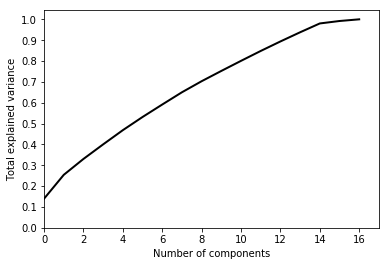

In [104]:
pca = PCA()
pca.fit(X_train_std)

# Plot the explained variances
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, len(X_train.columns))
plt.yticks(np.arange(0, 1.1, 0.1))
# plt.axvline(6, c='b')
# plt.axhline(0.9, c='r')
plt.show()

data_std = pd.concat([pd.DataFrame(X_train_std), pd.Series(y_train)]
data_std_melt = pd.melt(, id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data_std_melt, split=True, inner="quart")